In [1]:
from fastai.vision import *
import fastai
fastai.__version__

'1.0.61'

In [2]:
# ??Module

In [3]:
# import shutil
# shutil.rmtree(''../output')

# !pip install --upgrade pip

# !pip install --upgrade fastai

# !pip install --upgrade torch

In [4]:
import torch
torch.cuda.get_device_name(0)

'Tesla P100-PCIE-16GB'

In [5]:
# torch.cuda.empty_cache()

In [6]:
torch.cuda.memory_allocated()

0

> ***BIO MEDICAL IMAGE SEGMENTATION***

In [7]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
# %load_ext tensorboard
%load_ext tensorboard

In [8]:
from fastai.vision import *
from fastai.callbacks.hooks import *
from fastai.callbacks.tensorboard import*

In [9]:
import os
print(os.listdir("../input"))

['p-1-dataset']


In [10]:
path = pathlib.Path("../input/p-1-dataset/P_1 dataset")
path.ls()

[PosixPath('../input/p-1-dataset/P_1 dataset/train.csv'),
 PosixPath('../input/p-1-dataset/P_1 dataset/gt'),
 PosixPath('../input/p-1-dataset/P_1 dataset/train')]

In [11]:
path_lbl = path/'gt'
path_img = path/'train'

# >  *Classes and definitions* **Main code**


In [12]:
from fastai.vision.learner import*
from fastai.layers import *
from fastai.callbacks.hooks import *
# import fastai

In [13]:
def conv_norm_relu_sa(ni:int, nf:int, ks:int=3, stride:int=1, padding:int=None, bias:bool=None, is_1d:bool=False,
               norm_type:Optional[NormType]=NormType.Batch,  use_activ:bool=True, leaky:float=None,
               transpose:bool=False, init:Callable=nn.init.kaiming_normal_, self_attention:bool=False):
    if padding is None: padding = (ks-1)//2 if not transpose else 0
    bn = norm_type in (NormType.Batch, NormType.BatchZero)
    if bias is None: bias = not bn
    conv_func = nn.ConvTranspose2d if transpose else nn.Conv1d if is_1d else nn.Conv2d
    conv = init_default(conv_func(ni, nf, kernel_size=ks, bias=bias, stride=stride, padding=padding), init)
    if   norm_type==NormType.Weight:   conv = weight_norm(conv)
    elif norm_type==NormType.Spectral: conv = spectral_norm(conv)
    layers = [conv]
    if use_activ: layers.append(relu(True, leaky=leaky))
    if bn: layers.append((nn.BatchNorm1d if is_1d else nn.BatchNorm2d)(nf))
    if self_attention: layers.append(SelfAttention(nf))
    return nn.Sequential(*layers)

In [14]:
def indx_where_sz_changes(sizes:Sizes) -> List[int]:
#      Here when the size of feature map changes during encoder their previous module indexs are noted
#      Input is Sizes from encoder part
    feature_szs = [size[-1] for size in sizes]
    sfs_idxs = list(np.where(np.array(feature_szs[:-1]) != np.array(feature_szs[1:]))[0])
    if feature_szs[0] != feature_szs[1]: sfs_idxs = [0] + sfs_idxs
    return sfs_idxs

In [15]:
class Unet_block_clss(Module):
    def __init__(self, up_in_c:int, x_in_c:int, hook:Hook, final_div:bool=True, blur:bool=False, leaky:float=None,
                 self_attention:bool=False, **kwargs):
#         From encoder part activations are taken from hooks() and are concatenated to decoder activations
        self.hook = hook
        self.shuf = PixelShuffle_ICNR(up_in_c, up_in_c//2, blur=blur, leaky=leaky, **kwargs)
        self.bn = batchnorm_2d(x_in_c)
        ni = up_in_c//2 + x_in_c
        nf = ni if final_div else ni//2
        self.conv1 = conv_norm_relu_sa(ni, nf, leaky=leaky, **kwargs)
        self.conv2 = conv_norm_relu_sa(nf, nf, leaky=leaky, self_attention=self_attention, **kwargs)
        self.relu = relu(leaky=leaky)

    def forward(self, up_in:Tensor) -> Tensor:
        s = self.hook.stored
        up_out = self.shuf(up_in)
        ssh = s.shape[-2:]
#         If sizes are not equal interpolation is done velow
        if ssh != up_out.shape[-2:]:
            up_out = F.interpolate(up_out, s.shape[-2:], mode='nearest')
        cat_x = self.relu(torch.cat([up_out, self.bn(s)], dim=1))
        return self.conv2(self.conv1(cat_x))



In [16]:
class Decoder_clss(SequentialEx):
    def __init__(self, encoder:nn.Module, n_classes:int, img_size:Tuple[int,int]=(256,256), blur:bool=False, blur_final=True, self_attention:bool=False,
                 y_range:Optional[Tuple[float,float]]=None,
                 last_cross:bool=True, bottle:bool=False, **kwargs):
        imsize = img_size
#         Encoder part sizes
        sfs_szs = model_sizes(encoder, size=imsize)
        sfs_idxs = list(reversed(indx_where_sz_changes(sfs_szs)))
#         Storing hooks for every layer in sfs_idxs
        self.sfs = hook_outputs([encoder[i] for i in sfs_idxs], detach=False)
#         In the whole code x is used to help with size and channels
        x = dummy_eval(encoder, imsize).detach()

        ni = sfs_szs[-1][1]
        middle_conv = nn.Sequential(conv_norm_relu_sa(ni, ni*2, **kwargs),
                                    conv_norm_relu_sa(ni*2, ni, **kwargs)).eval()
        x = middle_conv(x)
        layers = [encoder, batchnorm_2d(ni), nn.ReLU(), middle_conv]

        for i,idx in enumerate(sfs_idxs):
            not_final = i!=len(sfs_idxs)-1
            up_in_c, x_in_c = int(x.shape[1]), int(sfs_szs[idx][1])
            do_blur = blur and (not_final or blur_final)
            sa = self_attention and (i==len(sfs_idxs)-3)
            unet_block = Unet_block_clss(up_in_c, x_in_c, self.sfs[i], final_div=not_final, blur=do_blur, self_attention=sa,
                                   **kwargs).eval()
            layers.append(unet_block)
            x = unet_block(x)

        ni = x.shape[1]
        if imsize != sfs_szs[0][-2:]: layers.append(PixelShuffle_ICNR(ni, **kwargs))
        x = PixelShuffle_ICNR(ni)(x)
        if imsize != x.shape[-2:]: layers.append(Lambda(lambda x: F.interpolate(x, imsize, mode='nearest')))
        if last_cross:
            layers.append(MergeLayer(dense=True))
            ni += in_channels(encoder)
            layers.append(res_block(ni, bottle=bottle, **kwargs))
        layers += [conv_norm_relu_sa(ni, n_classes, ks=1, use_activ=False, **kwargs)]
#         if y_range is not None: layers.append(SigmoidRange(*y_range))
        super().__init__(*layers)
# Removing hooks when exiting with as loop
    def __del__(self):
        if hasattr(self, "sfs"): self.sfs.remove()

In [17]:
def _default_split(m:nn.Module): return (m[1],)
# Split a resnet style model
def _resnet_split(m:nn.Module): return (m[0][6],m[1])
def _vgg_split(m:nn.Module): return (m[0][0][22],m[1])

_default_meta     = {'cut':None, 'split':_default_split}
_resnet_meta      = {'cut':-2, 'split':_resnet_split }
_vgg_meta         = {'cut':-1, 'split':_vgg_split}

model_meta = {
    models.resnet18 :{**_resnet_meta}, models.resnet34: {**_resnet_meta},
    models.resnet50 :{**_resnet_meta}, models.resnet101:{**_resnet_meta},
    models.resnet152:{**_resnet_meta},
#     models.vgg11_bn:{**_vgg_meta}, models.vgg13_bn:{**_vgg_meta}, models.vgg16_bn:{**_vgg_meta}, models.vgg19_bn:{**_vgg_meta},

}

def cnn_config(arch):
    "Get the metadata associated with `arch`."
    torch.backends.cudnn.benchmark = True
    return model_meta.get(arch, _default_meta)

In [18]:
def learner_unet(data:DataBunch, arch:Callable, pretrained:bool=True, blur_final:bool=True,
                 norm_type:Optional[NormType]=None, split_on:Optional[SplitFuncOrIdxList]=None, blur:bool=False,
                 self_attention:bool=False, y_range:Optional[Tuple[float,float]]=None, last_cross:bool=True,
                 bottle:bool=False, cut:Union[int,Callable]=None, **learn_kwargs:Any)->Learner:
    meta = cnn_config(arch)
    body = create_body(arch, pretrained, cut)
    try:    size = data.train_ds[0][0].size
    except: size = next(iter(data.train_dl))[0].shape[-2:]
    model = to_device(Decoder_clss(body, n_classes=data.c, img_size=size, blur=blur, blur_final=blur_final,
          self_attention=self_attention, y_range=y_range, norm_type=norm_type, last_cross=last_cross,
          bottle=bottle), data.device)
    learn = Learner(data, model, **learn_kwargs)
    learn.split(ifnone(split_on, meta['split']))
    if pretrained: learn.freeze()
    apply_init(model[2], nn.init.kaiming_normal_)
    return learn

## Data

In [19]:
fnames = get_image_files(path_img)
fnames[:3]

[PosixPath('../input/p-1-dataset/P_1 dataset/train/001-5-1.jpg'),
 PosixPath('../input/p-1-dataset/P_1 dataset/train/001-028-1.jpg'),
 PosixPath('../input/p-1-dataset/P_1 dataset/train/001-034-1.jpg')]

In [20]:
lbl_names = get_image_files(path_lbl)
lbl_names[:3]

[PosixPath('../input/p-1-dataset/P_1 dataset/gt/001-038-1gt.png'),
 PosixPath('../input/p-1-dataset/P_1 dataset/gt/001-028-1gt.png'),
 PosixPath('../input/p-1-dataset/P_1 dataset/gt/001-8-2gt.png')]

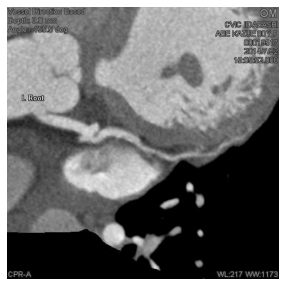

In [21]:
img_f = fnames[0]
img = open_image(img_f)
img.show(figsize=(5,5))

In [22]:
img_f


PosixPath('../input/p-1-dataset/P_1 dataset/train/001-5-1.jpg')

In [23]:
get_y_fn = lambda x: path_lbl/f'{x.stem}gt.png'

In [24]:
get_y_fn(img_f)

PosixPath('../input/p-1-dataset/P_1 dataset/gt/001-5-1gt.png')

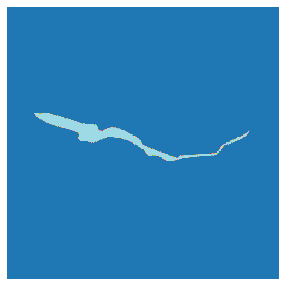

In [25]:
mask = open_mask(get_y_fn(img_f))
mask.show(figsize=(5,5), alpha=1)

In [26]:
len(np.unique(mask.data))

223

In [27]:
src_size = np.array(mask.shape[1:])
src_size,print(mask.data)

tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]])


(array([512, 512]), None)

In [28]:
# torch.set_printoptions(profile="full")
# print(mask.data)
# torch.set_printoptions(profile="default")

In [29]:
np.unique(mask.data)

array([  0,   1,   2,   3, ..., 252, 253, 254, 255])

In [30]:
codes = ['yes' for i in range(256)]

In [31]:
len(codes)

256

## Datasets and **Half-res Training**

In [32]:
# Important to note
# First model is trained on half resolution and then in Full training part model is trained on full resolution
size = src_size//2
bs=8
print(size)

[256 256]


In [33]:
src = (SegmentationItemList.from_folder(path_img)
       .split_by_rand_pct(valid_pct=0.2, seed=None)
       .label_from_func(get_y_fn,classes = codes))

In [34]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs, num_workers=0)
        .normalize(imagenet_stats))

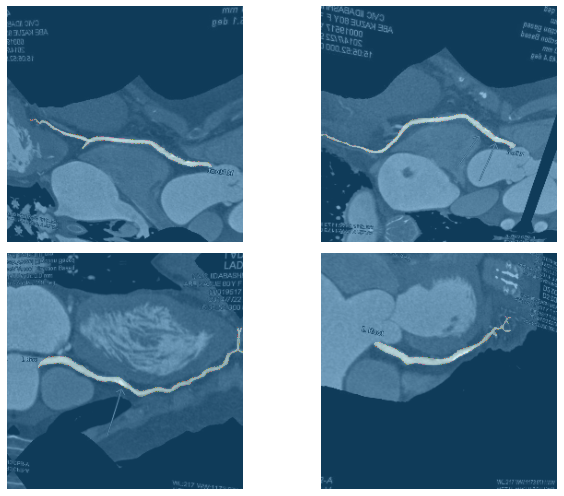

In [35]:
data.show_batch(2, figsize=(10,7))

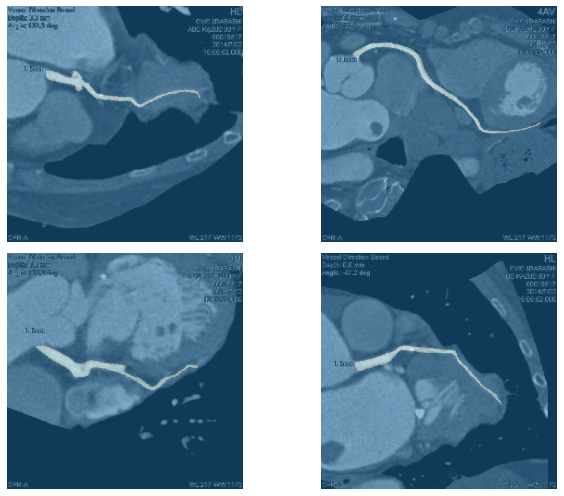

In [36]:
data.show_batch(2, figsize=(10,7), ds_type=DatasetType.Valid)

## Model

In [37]:
name2id = {v:k for k,v in enumerate(codes)}
# void_code = name2id['Void']

def my_acc(input, target):
#     print("inputsize = ",input.size(),"\n tar_size = ",target.size())
    target = target.squeeze(1)
#     mask = target != void_code
    return (input.argmax(dim=1)==target).float().mean()

In [38]:
def my_dice(input:Tensor, targs:Tensor, iou:bool=False, eps:float=1e-8)->Rank0Tensor:
    "Dice coefficient metric for binary target. If iou=True, returns iou metric, classic for segmentation problems."
    n = targs.shape[0]
    targs = targs.squeeze(1)
    input = input.argmax(dim=1).view(n,-1)
    targs = targs.view(n,-1)
    targs1 = (targs>0).float()
    input1 = (input>0).float()
    ss = (input == targs).float()
    intersect = (ss * targs1).sum(dim=1).float()
    union = (input1+targs1).sum(dim=1).float()
    if not iou: l = 2. * intersect / union
    else: l = intersect / (union-intersect+eps)
    l[union == 0.] = 1.
    return l.mean()

In [39]:
# def dice_(input:Tensor, targs:Tensor, iou:bool=True, eps:float=1e-8)->Rank0Tensor:
#     n = targs.shape[0]
#     dice_sum = torch.as_tensor([0.], dtype=torch.float32, device=targs.device)
#     for i in range(1, targs.max()+1):
#         input_flatten = input[:,i-1,:,:].flatten(1,-1).float()
#         targs_flatten = targs.flatten(1,-1).float()
#         input_flatten[input_flatten>0.5], input_flatten[input_flatten<=0.5] = 1., 0.
#         targs_flatten[targs_flatten!=i], targs_flatten[targs_flatten==i] = 0, 1
#         intersect = (input_flatten * targs_flatten).sum(dim=1)
#         union = (input_flatten + targs_flatten).sum(dim=1)
#         if not iou: l = 2. * intersect / union
#         else: l = intersect / (union-intersect+eps)
#         l[union == 0.] = 1
#         dice_sum += l.mean()
#     return dice_sum / targs.max()

In [40]:
metrics=[partial(my_dice,iou = False),my_acc]
# metrics=accuracy


In [41]:
wd=1e-2

In [42]:
# learn.destroy()
# gc.collect()

In [43]:
learn = learner_unet(data, models.resnet34, metrics=metrics,callback_fns=[ActivationStats], wd=wd,path = ".", model_dir="")

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth


In [44]:
# from tensorboardX import SummaryWriter
# from fastai.callback import Callback
# from pathlib import Path
# import shutil


# class TensorboardLogger1(Callback):
#     """
#     A general Purpose Logger for TensorboardX
#     Also save a .txt file for the important parts
#     """

#     def __init__(self, learner, log_name, del_existing=False, histogram_freq=100):
#         """
#         Learner is the ConvLearner
#         log_name: name of the log directory to be formed. Will be input
#         for each run
#         cfgtxt: HyperParams
#         del_existing: To run the experiment from scratch and remove previous logs
#         """
#         super().__init__()
#         self.learn = learner
#         self.model = learner.model
#         self.md = learner.data

#         self.metrics_names = ["validation_loss"]
#         self.metrics_names += [m.__name__ for m in learner.metrics]

#         self.best_met = 0

#         self.histogram_freq = histogram_freq

#         path = Path(self.md.path) / "logs"
#         self.log_name = log_name
#         self.log_dir = path / log_name

#         self.init_logs(self.log_dir, del_existing)
#         self.init_tb_writer()

#     def init_logs(self, log_dir, del_existing):
#         if log_dir.exists():
#             if del_existing:
#                 print(f'removing existing log with same name {log_dir.stem}')
#                 shutil.rmtree(self.log_dir)

#     def init_tb_writer(self):
#         self.writer = SummaryWriter(
#             comment='main_mdl', log_dir=str(self.log_dir))
#         self.writer.add_text('HyperParams', self.cfgtxt)


#     def on_batch_end(self, **kwargs):
#         self.trn_loss = kwargs['last_loss']
#         num_batch = kwargs['num_batch']
#         self.writer.add_scalar(
#             'trn_loss_batch', self.trn_loss, num_batch)

#     def on_epoch_end(self, **kwargs):
#         metrics = kwargs['last_metrics']
#         epoch = kwargs['epoch']
#         trn_loss = kwargs['smooth_loss']
#         self.writer.add_scalar('trn_loss', trn_loss, epoch)

#         for val, name in zip(metrics, self.metrics_names):
#             self.writer.add_scalar(name, val, epoch)

#         self.file_write(self.str_form.format(epoch,
#                                              self.trn_loss, *metrics))

#         m = metrics[1]
#         if m > self.best_met:
#             self.best_met = m
#             self.learn.save(self.log_name)

#     def on_train_end(self, **kwargs):
#         self.writer.add_text('Total Epochs', str(kwargs['epoch']))
#         self.writer.close()
#         self.file_write(f'Epochs done, {kwargs["epoch"]}')

#     def file_write(self, outstr):
#         with open(self.fw_, 'a') as f:
#             f.write(outstr)

In [45]:
# from tensorboard import *
# writer = SummaryWriter(comment='Demo')
# mycallback = partial(TensorBoardFastAI, writer, track_weight=True, track_grad=True, metric_names=['val loss','dicee', 'accuracy'])
# learn.callback_fns.append(mycallback)

In [46]:
from fastai.callbacks.tensorboard import*

In [47]:
# Tensorboard Integration
project_id = 'ProjectP_1'
# del_existing = True
tboard_path = Path('data/tmp/tensorboard/' + project_id)
tb_calb = LearnerTensorboardWriter(learn,tboard_path,name='tb_1',loss_iters=1,hist_iters=10,stats_iters=10)
# tb_calb2 = TensorboardLogger1(learn,'tb_n',del_existing=del_existing) #TensorBoardLogger1 Class is in above cells
# tb_calb1 = partial(LearnerTensorboardWriter,base_dir=tboard_path,name='tb_1',loss_iters=1,hist_iters=10,stats_iters=10)
# learn.callback_fns.append(tb_calb1)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


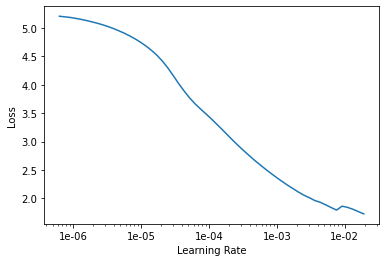

In [48]:
lr_find(learn)
learn.recorder.plot()

In [49]:
lr=4e-4

In [50]:
learn.fit_one_cycle(100, slice(lr), pct_start=0.9)

epoch,train_loss,valid_loss,my_dice,my_acc,time
0,4.867291,3.696710,0.000024,0.006445,00:01
1,4.337345,2.953999,0.000007,0.163074,00:01
2,3.888893,2.125908,0.000000,0.610623,00:01
3,3.421953,1.320365,0.000000,0.896460,00:01
4,2.954609,0.880024,0.000000,0.950284,00:01
5,2.553115,0.891119,0.000000,0.964285,00:01
6,2.257193,1.035465,0.000000,0.970785,00:01
7,2.057770,1.140147,0.000000,0.974872,00:01
8,1.905599,1.119681,0.000000,0.977267,00:01
9,1.789175,0.986044,0.000000,0.978629,00:01


In [51]:
# !tensorboard --logdir=data/tmp/tensorboard/ProjectP_1/tb_1
# !tensorboard --logdir=data/tmp/tensorboard/ProjectP_1/tb_1 --host localhost --port 8088
# !tensorboard --bind_all --port 8080 --logdir data/tmp/tensorboard/ProjectP_1/tb_1
# %tensorboard --logdir=$tboard_path --port=6006

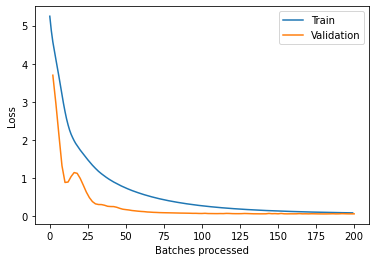

In [52]:
learn.recorder.plot_losses()

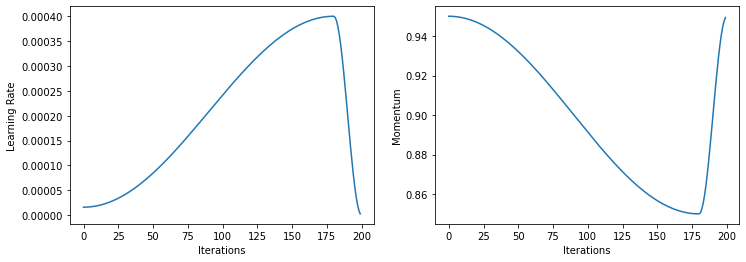

In [53]:
learn.recorder.plot_lr(show_moms = True)

In [54]:
learn.save('stage-1')

In [55]:
learn.load('stage-1');

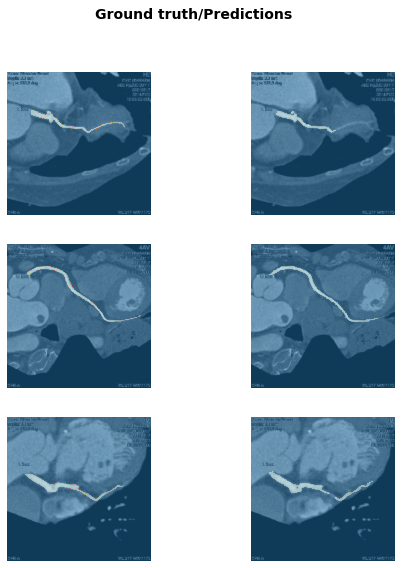

In [56]:
learn.show_results(rows=3, figsize=(8,9))

In [57]:
# x1 = learn.data.train_ds[0][0]
# show_image(x1)

# show_image(learn.predict(x1)[0])

# show_image(learn.predict(x1)[1])

# show_image(learn.predict(x1)[0])

In [58]:


# img = learn.data.train_ds[0][0]
# fig=plt.figure(figsize=(16, 16))
# rows = 2; columns = 2
# fig.add_subplot(rows, columns, 1)
# plt.imshow(img)
# for i in range(3):
#     fig.add_subplot(rows, columns, i+2)
#     plt.imshow(learn.predict(img)[i])
# plt.show()
    


In [59]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


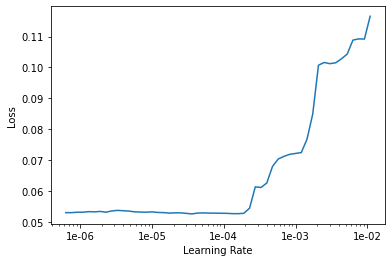

In [60]:
lr_find(learn)
learn.recorder.plot()

In [61]:
lrs = slice(lr/500,lr/5)

In [62]:
learn.fit_one_cycle(100, lrs, pct_start=0.8)

epoch,train_loss,valid_loss,my_dice,my_acc,time
0,0.053938,0.057302,0.607313,0.989792,00:01
1,0.053054,0.057955,0.607811,0.989822,00:01
2,0.053388,0.057629,0.608225,0.989841,00:01
3,0.053466,0.056487,0.609390,0.989832,00:01
4,0.052781,0.055951,0.609453,0.989783,00:01
5,0.053625,0.055925,0.609567,0.989816,00:01
6,0.053223,0.056082,0.610587,0.989865,00:01
7,0.052906,0.056140,0.609621,0.989847,00:01
8,0.053000,0.055995,0.609379,0.989850,00:01
9,0.053090,0.056123,0.610280,0.989883,00:01


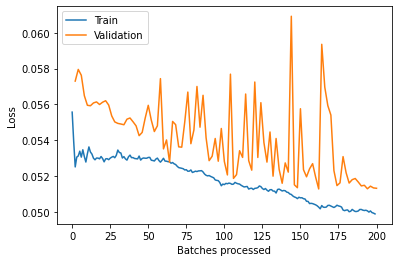

In [63]:
learn.recorder.plot_losses()

In [64]:
learn.save('stage-2');

## Full-res training ....

If out of CUDA memory restart kernel

In [65]:
# torch.cuda.empty_cache()

In [66]:
# # learn.destroy()
# gc.collect()

In [67]:
from fastai.utils.mem import *

In [68]:
# Now training on full resolution
size = src_size
print(size)
free = gpu_mem_get_free_no_cache()
# the max size of bs depends on the available GPU RAM
if free > 8200: bs=4
else:           bs=2
print(f"using bs={bs}, have {free}MB of GPU RAM free")


[512 512]
using bs=2, have 6103MB of GPU RAM free


In [69]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

In [70]:
learn = learner_unet(data, models.resnet34, metrics=metrics, wd=wd,path = ".", model_dir="")

In [71]:
learn.load('stage-2');

In [72]:
# learn.callback_fns.append(partial(LearnerTensorboardWriter, 
#                                     base_dir=tboard_path, 
#                                     name='tb_2'))

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


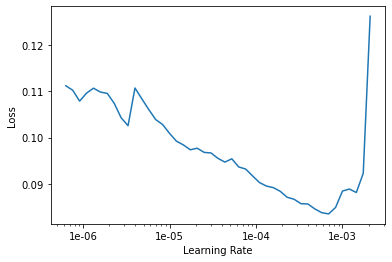

In [73]:
lr_find(learn)
learn.recorder.plot()

In [74]:
lr=1e-4

In [75]:
learn.fit_one_cycle(100, slice(lr), pct_start=0.8)

epoch,train_loss,valid_loss,my_dice,my_acc,time
0,0.118633,0.068893,0.527301,0.986314,00:04
1,0.097279,0.075380,0.510361,0.984402,00:04
2,0.088530,0.068900,0.519661,0.986110,00:04
3,0.085484,0.066099,0.514251,0.987125,00:03
4,0.082216,0.062993,0.530291,0.987482,00:03
5,0.078165,0.060452,0.558511,0.987940,00:03
6,0.075655,0.058173,0.573899,0.988201,00:03
7,0.073383,0.056908,0.585827,0.988492,00:03
8,0.070643,0.055079,0.594261,0.989098,00:03
9,0.068043,0.054779,0.595031,0.989284,00:03


In [76]:
# tensorboard --logdir=data/tensorboard/project_id/tb_2

In [77]:
learn.save('stage-1-big')

In [78]:
learn.load('stage-1-big');

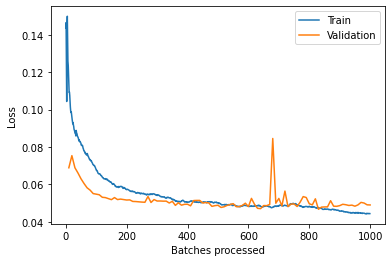

In [79]:
learn.recorder.plot_losses()

In [80]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


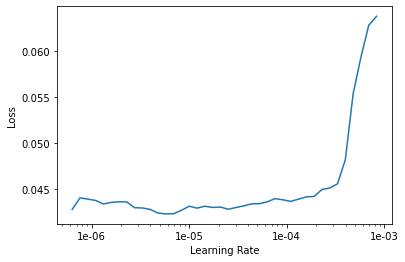

In [81]:
lr_find(learn)
learn.recorder.plot()

In [82]:
lrs = slice(1e-5,lr/1)

In [83]:
learn.fit_one_cycle(100, lrs)

epoch,train_loss,valid_loss,my_dice,my_acc,time
0,0.043921,0.049590,0.632948,0.990614,00:04
1,0.043615,0.048598,0.635922,0.990697,00:04
2,0.043435,0.049567,0.633498,0.990614,00:04
3,0.043647,0.049765,0.631916,0.990579,00:04
4,0.044230,0.048576,0.635197,0.990710,00:04
5,0.043665,0.048910,0.635852,0.990739,00:04
6,0.043564,0.050403,0.630178,0.990524,00:03
7,0.043444,0.049500,0.637755,0.990774,00:03
8,0.043521,0.048807,0.635848,0.990683,00:04
9,0.043773,0.049891,0.630671,0.990555,00:03


In [84]:
learn.save('stage-2-big')

In [85]:
learn.load('stage-2-big');

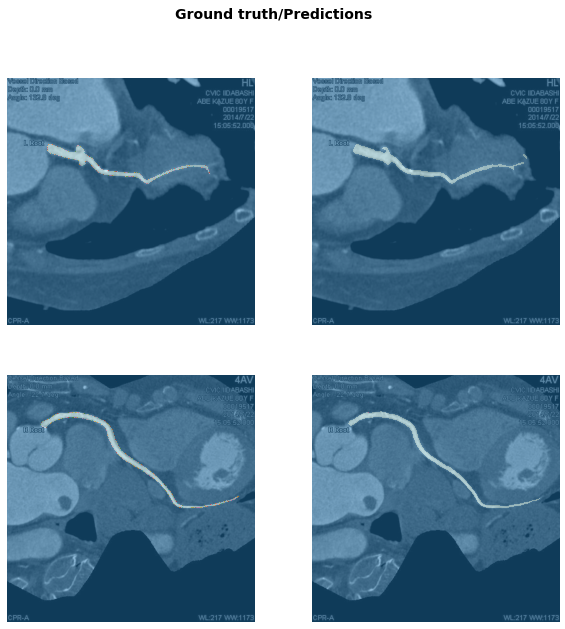

In [86]:
learn.show_results(rows=3, figsize=(10,10))

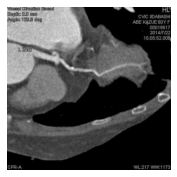

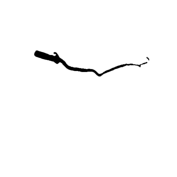

In [87]:
x1 = learn.data.valid_ds[0][0]
show_image(x1)

show_image(learn.predict(x1)[1])

*********************Completed************************************************

Rough Area

In [88]:
from fastai.vision.models.unet import *

In [89]:
import torch
import torch.nn as nn

In [90]:
from fastai.torch_core import *
from fastai.layers import *
from fastai.callbacks.hooks import *

In [91]:
# class Unet_block_clss(nn.Module):
#     "A quasi-UNet block, using `PixelShuffle_ICNR upsampling`."
#     def __init__(self, up_in_c:int, x_in_c:int, hook:Hook, final_div:bool=True, blur:bool=False, leaky:float=None,
#                  self_attention:bool=False, **kwargs):
#         self.hook = hook
#         self.shuf = PixelShuffle_ICNR(up_in_c, up_in_c//2, blur=blur, leaky=leaky, **kwargs)
#         self.bn = batchnorm_2d(x_in_c)
#         ni = up_in_c//2 + x_in_c
#         nf = ni if final_div else ni//2
#         self.conv1 = conv_layer(ni, nf, leaky=leaky, **kwargs)
#         self.conv2 = conv_layer(nf, nf, leaky=leaky, self_attention=self_attention, **kwargs)
#         self.relu = relu(leaky=leaky)

#     def forward(self, up_in:Tensor) -> Tensor:
#         s = self.hook.stored
#         up_out = self.shuf(up_in)
#         ssh = s.shape[-2:]
#         if ssh != up_out.shape[-2:]:
#             up_out = F.interpolate(up_out, s.shape[-2:], mode='nearest')
#         cat_x = self.relu(torch.cat([up_out, self.bn(s)], dim=1))
#         return x + self.conv2(self.conv1(cat_x))